In [1]:
from google.colab import files

# This will prompt you to select the kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deepanshanmugam","key":"c0b8b2f3db364205fece69dccfe97e0a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c copy-of-regression-with-anns

  0% 0.00/8.53M [00:00<?, ?B/s]
100% 8.53M/8.53M [00:00<00:00, 92.3MB/s]


In [5]:
!unzip -q copy-of-regression-with-anns.zip


In [8]:
!ls
!pwd

copy-of-regression-with-anns.zip  sample_data		 test.csv
kaggle.json			  sample_submission.csv  train.csv
/content


In [31]:
# from zipfile import ZipFile
# import os
import pandas as pd
import os

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')




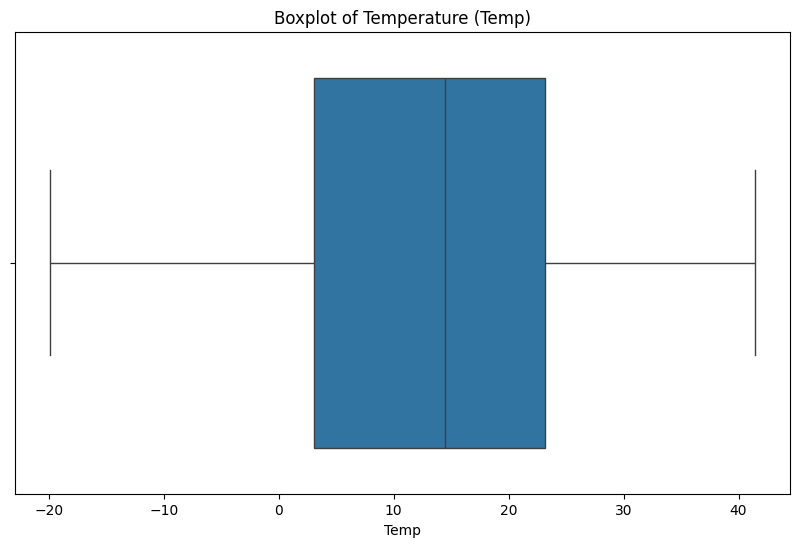

(172237, 37) (43060, 37)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

test_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# Now, you can drop 'Unnamed: 0' from train and validation datasets if you haven't already
train_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Identify numerical and categorical features
numerical_features = ['SO2', 'NO2', 'CO', 'O3', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed']
categorical_features = ['WinDir', 'Station']  # Assuming 'WinDir' and 'Station' are categorical

# Define the ColumnTransformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the train dataset into X (features) and y (target)
X_train_full = train_df.drop('PM2.5', axis=1)
y_train_full = train_df['PM2.5']

# Further split the full training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(test_df)

# Display the shape of the processed feature sets to confirm
X_train_preprocessed.shape, X_val_preprocessed.shape, X_test_preprocessed.shape


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `train_df` is your DataFrame
# Visualizing outliers for 'Temp' feature using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['Temp'])
plt.title('Boxplot of Temperature (Temp)')
plt.show()

# Function to remove outliers based on the IQR method for all numerical features
def remove_outliers(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtering out outliers
        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

# Removing outliers from the train_df
train_df_filtered = remove_outliers(train_df, numerical_features)

# You might want to reset index after removing outliers
train_df_filtered.reset_index(drop=True, inplace=True)


# Split the filtered train dataset into X (features) and y (target)
X_train_full_filtered = train_df_filtered.drop('PM2.5', axis=1)
y_train_full_filtered = train_df_filtered['PM2.5']

# Further split the full training data into training and validation sets
X_train_filtered, X_val_filtered, y_train_filtered, y_val_filtered = train_test_split(X_train_full_filtered, y_train_full_filtered, test_size=0.2, random_state=42)

# Apply preprocessing on the filtered dataset
X_train_preprocessed_filtered = preprocessor.fit_transform(X_train_filtered)
X_val_preprocessed_filtered = preprocessor.transform(X_val_filtered)

# Display the shape of the processed feature sets to confirm
print(X_train_preprocessed_filtered.shape, X_val_preprocessed_filtered.shape)



In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Convert the sparse matrix to a dense matrix, then to PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed.toarray(), dtype=torch.float32) if hasattr(X_train_preprocessed, 'toarray') else torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_preprocessed.toarray(), dtype=torch.float32) if hasattr(X_val_preprocessed, 'toarray') else torch.tensor(X_val_preprocessed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_preprocessed.toarray(), dtype=torch.float32) if hasattr(X_test_preprocessed, 'toarray') else torch.tensor(X_test_preprocessed, dtype=torch.float32)


# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [44]:
#define the ANN model architecture
# class RegressionANN(nn.Module):
#     def __init__(self, input_size):
#         super(RegressionANN, self).__init__()
#         self.layer1 = nn.Linear(input_size, 128)
#         self.layer2 = nn.Linear(128, 64)
#         self.output_layer = nn.Linear(64, 1)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.layer1(x))
#         x = self.relu(self.layer2(x))
#         x = self.output_layer(x)
#         return x

import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedRegressionANN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedRegressionANN, self).__init__()
        # Increase the depth and adjust the size of each layer
        self.layer1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization layer
        self.dropout1 = nn.Dropout(0.1)  # Dropout layer

        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.1)

        self.layer4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.1)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)
        x = self.output_layer(x)
        return x



In [45]:
# Initialize the ANN model
input_size = X_train_tensor.shape[1]
# model = RegressionANN(input_size)
model = EnhancedRegressionANN(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


In [46]:
epochs = 20
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')


Epoch 1, Training Loss: 3491.317138671875, Validation Loss: 1458.2066123539928
Epoch 2, Training Loss: 3695.889892578125, Validation Loss: 1475.2966111770281
Epoch 3, Training Loss: 3859.514404296875, Validation Loss: 1360.440220438308
Epoch 4, Training Loss: 3723.415283203125, Validation Loss: 1368.1505966269362
Epoch 5, Training Loss: 4188.22509765625, Validation Loss: 1299.9326051925345
Epoch 6, Training Loss: 4183.79052734375, Validation Loss: 1367.4689700181527
Epoch 7, Training Loss: 3985.202392578125, Validation Loss: 1287.5836570979977
Epoch 8, Training Loss: 3992.720458984375, Validation Loss: 1424.6902679874117
Epoch 9, Training Loss: 4060.5859375, Validation Loss: 1329.125448850286
Epoch 10, Training Loss: 3947.298095703125, Validation Loss: 1338.1229619990213
Epoch 11, Training Loss: 4056.73291015625, Validation Loss: 1228.3067900319054
Epoch 12, Training Loss: 4290.8662109375, Validation Loss: 1318.04568189855
Epoch 13, Training Loss: 4149.57568359375, Validation Loss: 129

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Collect all predictions and actual values
all_predictions = []
all_actuals = []

with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        all_predictions.extend(outputs.view(-1).tolist())
        all_actuals.extend(targets.view(-1).tolist())

# Convert lists to arrays for calculation
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

# Calculate MAE and RMSE
mae = mean_absolute_error(all_actuals, all_predictions)
rmse = sqrt(mean_squared_error(all_actuals, all_predictions))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Square Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 21.929736672006605
Root Mean Square Error (RMSE): 35.49037139792358


In [55]:
from google.colab import drive

test_predictions = []
with torch.no_grad():
    test_predictions = model(X_test_tensor).view(-1).numpy()

# Assuming `test_predictions` contains the predictions for the test dataset
# and `test_df` is your test DataFrame which should have the 'ID' column

print(test_df.head())

# Generate IDs based on the length of your predictions
IDs = np.arange(len(test_predictions))

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    # 'ID': test_df.iloc[:, 0],  # Make sure your test DataFrame has an 'ID' column
    'ID': IDs,
    'PM2.5': test_predictions.flatten()  # Flatten the predictions if necessary
})


# Mount Google Drive
drive.mount('/content/drive')
# Save the DataFrame to a .csv file for submission
submission_file_path = '/content/drive/My Drive/submission_ann_regression.csv'
submission_df.to_csv(submission_file_path, index=False)

submission_df.head()

# Prepare your submission based on the test predictions


    SO2   NO2      CO     O3  Temp   Press  DewP  Rain  WinDir  WinSpeed  \
0  31.0  63.0  1600.0  200.0  30.9   999.4  14.1   0.0       8       1.9   
1  12.0  64.0  2600.0    2.0   7.2  1024.2   4.7   0.0      10       1.1   
2   3.0  32.0  2000.0   11.0  15.8  1012.2  14.7   0.0       2       1.0   
3   2.0  44.0   400.0  120.0  28.2   996.7  14.4   0.0      11       1.7   
4  13.0  63.0   700.0   16.0  11.9  1007.3   3.4   0.0       3       0.5   

   Station  
0        3  
1       11  
2        2  
3        8  
4        0  
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,PM2.5
0,0,118.829895
1,1,136.560089
2,2,161.615295
3,3,31.166435
4,4,53.306694
